In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 26 16:09:11 2017

@author: cbothore
"""


import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle
from collections import Counter
import community 

# 定义社交网络图

In [2]:
def properties(g):
    """
    Computes simple and classic graph metrics.

    Parameters
    ----------
    g : graph
       A networkx graph
    """
    # networkx short summary of information for the graph g
    print(nx.info(g))
    
    # Draw the degree distribution. Powerlow distribution for a real (complex) network
    plt.figure(num=None)
    fig = plt.figure(1)
    degree_sequence=[d for n, d in g.degree()] # degree sequence
    print("Degree sequence %s" % degree_sequence)
    plt.hist(degree_sequence, bins='auto')  
    plt.title("powerlaw degree distribution")
    plt.ylabel("# nodes")
    plt.xlabel("degree")
    plt.show()
    pylab.close()
    del fig
    
# 偏心率：节点A的偏心率被定义为A和所有其他节点之间的最大距离。 可以使用nx.eccentricity（）函数找到它。 
# 如果偏心率为1，则他与所有人相连
    precomputed_eccentricity = nx.eccentricity(g) # costly step, we save time here!
    print("Graph density %f" % nx.density(g))
    print("Diameter (maximum eccentricity): %d" % nx.diameter(g,precomputed_eccentricity))
    print("Radius (minimum eccentricity): %d" % nx.radius(g,precomputed_eccentricity)) #The radius is the minimum eccentricity.
    print("Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): %s" % np.mean(list(precomputed_eccentricity.values())))
    print("Center is composed of %d nodes (nodes with eccentricity equal to radius)" % len(nx.center(g, precomputed_eccentricity)))
    print("Periphery is composed of %d nodes (nodes with eccentricity equal to the diameter)" % len(nx.periphery(g,precomputed_eccentricity)))
    
# 聚类系数：据观察，在社交网络中共享联系的人倾向于形成关联。换句话说，社交网络中存在形成集群的趋势。
# 我们可以确定节点的集群，Local Clustering Coefficient，它是节点的朋友（即连接）彼此连接的对的一部分。
# 为了确定局部聚类系数，我们使用nx.clustering（Graph，Node）函数。
    print("Mean clustering coefficient %f" % np.mean(list(nx.clustering(g).values())))
    total_triangles=sum(nx.triangles(g).values())/3    
    print("Total number of triangles in graph: %d" % total_triangles)

 # 信息补充方法

In [3]:
def naive_method(graph, empty, attr):
    """   Predict the missing attribute with a simple but effective
    relational classifier. 
    
    The assumption is that two connected nodes are 
    likely to share the same attribute value. Here we chose the most frequently
    used attribute by the neighbors
    
    Parameters
    ----------
    graph : graph
       A networkx graph
    empty : list
       The nodes with empty attributes 
    attr : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.

    Returns
    -------
    predicted_values : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node (from empty), value is a list of attribute values. Here 
       only 1 value in the list.
     """
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            if nbr in attr:
                for val in attr[nbr]:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values

# 准确率定义 （正确预测的个数占总预测值的比例）

In [4]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth :  : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0   
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction+=1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])          
        # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/sum(len(v) for v in pred.values())
   

# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")
print("Nb of users in our graph: %d" % len(G))

# load the profiles. 3 files for each type of attribute
# Some nodes in G have no attributes
# Some nodes may have 1 attribute 'location'
# Some nodes may have 1 or more 'colleges' or 'employers', so we
# use dictionaries to store the attributes
college={}
location={}
employer={}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)

print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))

# here are the empty nodes for whom your challenge is to find the profiles
empty_nodes=[]
with open('mediumRemovedNodes_60percent_of_empty_profile.pickle', 'rb') as handle:
    empty_nodes = pickle.load(handle)
print("Your mission, find attributes to %d users with empty profile" % len(empty_nodes))


# --------------------- Baseline method -------------------------------------#
# Try a naive method to predict attribute
# This will be a baseline method for you, i.e. you will compare your performance
# with this method
# Let's try with the attribute 'employer'


employer_predictions=naive_method(G, empty_nodes, employer)
location_predictions=naive_method(G, empty_nodes, location)
college_predictions=naive_method(G, empty_nodes, college)
groundtruth_employer={}
groundtruth_location={}
groundtruth_college={}
with open('mediumEmployer.pickle', 'rb') as handle:
    groundtruth_employer = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    groundtruth_location = pickle.load(handle)
with open('mediumCollege.pickle', 'rb') as handle:
    groundtruth_college = pickle.load(handle)
    
    
result_employer=evaluation_accuracy(groundtruth_employer,employer_predictions)
print("%f%% of the predictions are true" % result_employer)

result_location=evaluation_accuracy(groundtruth_location,location_predictions)
print("%f%% of the predictions are true" % result_location)

result_college=evaluation_accuracy(groundtruth_college,college_predictions)
print("%f%% of the predictions are true" % result_college)

print("Very poor result!!! Try to do better!!!!")

Nb of users in our graph: 811
Nb of users with one or more attribute college: 230
Nb of users with one or more attribute location: 336
Nb of users with one or more attribute employer: 297
Your mission, find attributes to 475 users with empty profile
19.696970% of the predictions are true
32.352941% of the predictions are true
28.404669% of the predictions are true
Very poor result!!! Try to do better!!!!


In [5]:
with open('mediumCollege.pickle', 'rb') as handle:
    college_full = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    location_full = pickle.load(handle)
with open('mediumEmployer.pickle', 'rb') as handle:
    employer_full = pickle.load(handle)

In [6]:
print("Nb of users with one or more attribute college: %d" % len(college_full))
print("Nb of users with one or more attribute location: %d" % len(location_full))
print("Nb of users with one or more attribute employer: %d" % len(employer_full))


Nb of users with one or more attribute college: 540
Nb of users with one or more attribute location: 811
Nb of users with one or more attribute employer: 730


In [8]:
location

{'U1313': ['norfolk virginia area'],
 'U8804': ['bologna area italy'],
 'U2649': ['urbana-champaign illinois area'],
 'U7310': ['greater seattle area'],
 'U22859': ['bengaluru area india'],
 'U1417': ['baltimore maryland area'],
 'U25611': ['greater boston area'],
 'U3895': ['greater boston area'],
 'U13005': ['bloomington normal illinois area'],
 'U2620': ['urbana-champaign illinois area'],
 'U5976': ['urbana-champaign illinois area'],
 'U9140': ['urbana-champaign illinois area'],
 'U16112': ['china'],
 'U15272': ['san francisco bay area'],
 'U3933': ['shanghai city china'],
 'U11562': ['urbana-champaign illinois area'],
 'U22071': ['greater chicago area'],
 'U15292': ['urbana-champaign illinois area'],
 'U14498': ['madison wisconsin area'],
 'U21990': ['greater chicago area'],
 'U24252': ['washington d.c. metro area'],
 'U12969': ['greater chicago area'],
 'U2180': ['urbana-champaign illinois area'],
 'U4447': ['greater minneapolis-st. paul area'],
 'U27582': ['urbana-champaign illin

In [7]:
# --------------------- Now your turn -------------------------------------#
# Explore, implement your strategy to fill empty profiles of empty_nodes


# and compare with the ground truth (what you should have predicted)
# user precision and recall measures

# lulu's challenge!

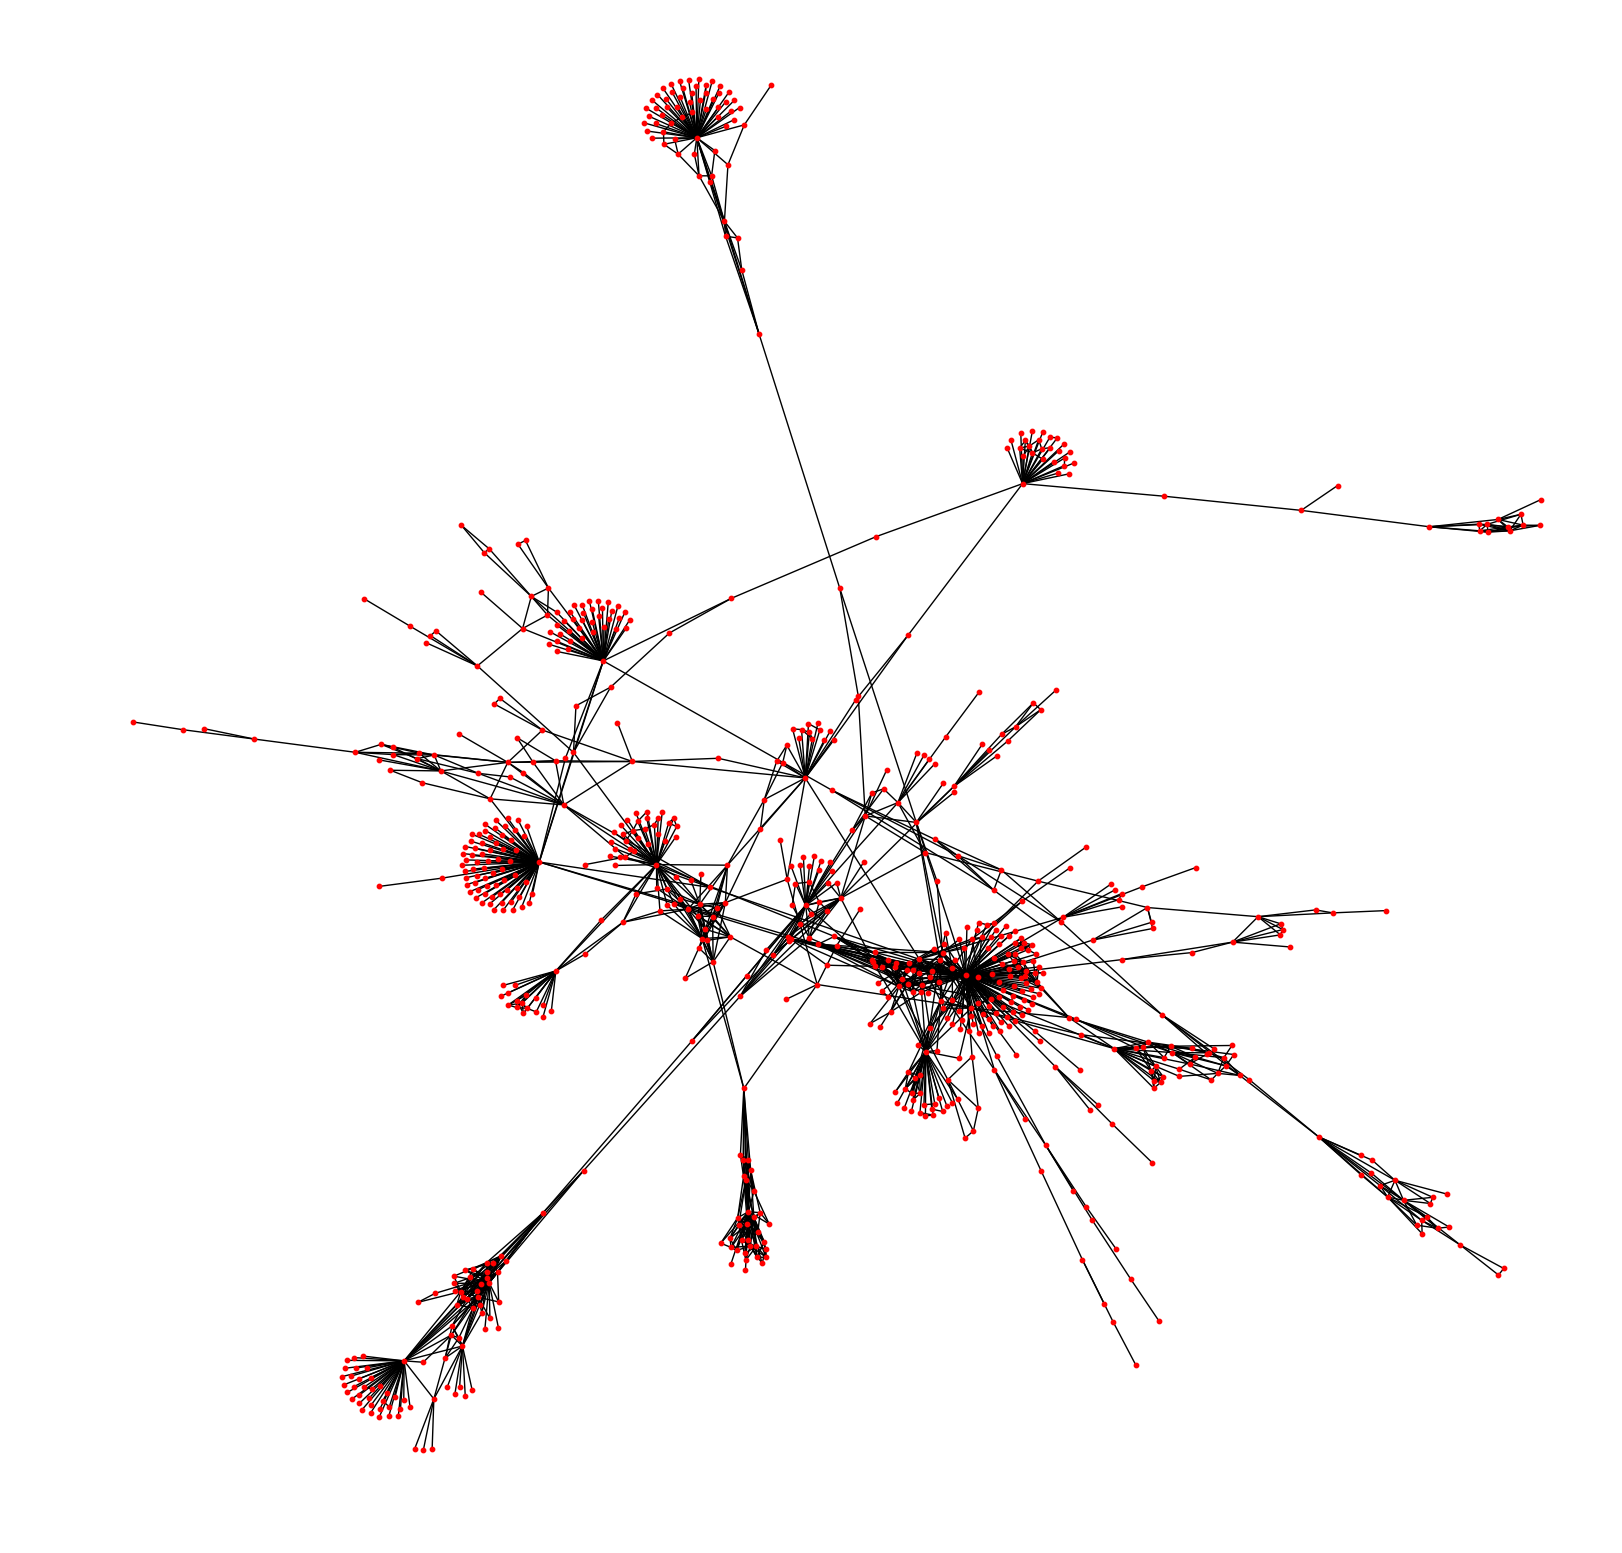

In [27]:
#initialze Figure
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)

# the spectral layout
pos = nx.spring_layout(G, iterations=100)

nx.draw(G,pos, with_labels = False, node_size = 10)
plt.show() #显示出来


Name: 
Type: Graph
Number of nodes: 811
Number of edges: 1597
Average degree:   3.9383
Degree sequence [8, 10, 4, 1, 4, 5, 2, 2, 1, 1, 1, 1, 3, 4, 8, 2, 1, 7, 16, 3, 3, 1, 2, 5, 1, 20, 6, 3, 6, 3, 1, 1, 8, 1, 9, 17, 1, 1, 1, 4, 1, 2, 1, 1, 1, 3, 6, 5, 5, 4, 1, 1, 4, 2, 1, 1, 1, 1, 10, 3, 4, 5, 1, 1, 3, 1, 1, 3, 10, 3, 2, 2, 5, 1, 1, 1, 10, 3, 1, 2, 2, 3, 2, 1, 3, 10, 2, 1, 4, 3, 5, 3, 1, 5, 9, 3, 3, 1, 4, 7, 1, 6, 1, 2, 2, 6, 1, 6, 1, 1, 6, 8, 1, 1, 1, 2, 3, 1, 6, 3, 58, 2, 2, 1, 1, 1, 2, 9, 2, 1, 5, 1, 1, 2, 1, 1, 1, 3, 4, 6, 1, 2, 9, 1, 3, 1, 1, 4, 5, 5, 2, 4, 1, 1, 5, 3, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 3, 1, 3, 5, 5, 8, 2, 3, 5, 1, 1, 3, 1, 5, 2, 3, 1, 2, 1, 2, 9, 1, 1, 1, 1, 3, 1, 1, 1, 6, 9, 1, 1, 1, 1, 9, 1, 1, 1, 1, 3, 17, 1, 1, 7, 11, 1, 1, 16, 3, 1, 2, 1, 16, 2, 2, 8, 6, 1, 6, 3, 2, 3, 2, 1, 6, 3, 1, 1, 2, 6, 5, 1, 1, 2, 18, 1, 1, 1, 2, 2, 11, 2, 1, 1, 5, 1, 3, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 2, 2, 4, 1, 3, 1, 1, 1, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 22, 1, 4, 9, 11, 3, 4, 8, 2, 4, 4, 

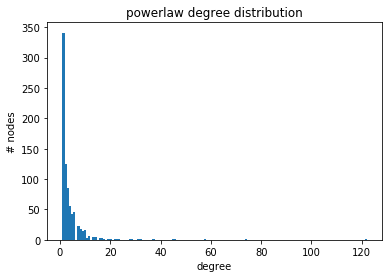

Graph density 0.004862
Diameter (maximum eccentricity): 19
Radius (minimum eccentricity): 10
Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): 13.241676942046857
Center is composed of 3 nodes (nodes with eccentricity equal to radius)
Periphery is composed of 5 nodes (nodes with eccentricity equal to the diameter)
Mean clustering coefficient 0.347288
Total number of triangles in graph: 1217


In [18]:
properties(G)

# Louvain 社区发现，将这些节点划分到不同的社区，根据相似性？

In [30]:
partition = community.best_partition(G)

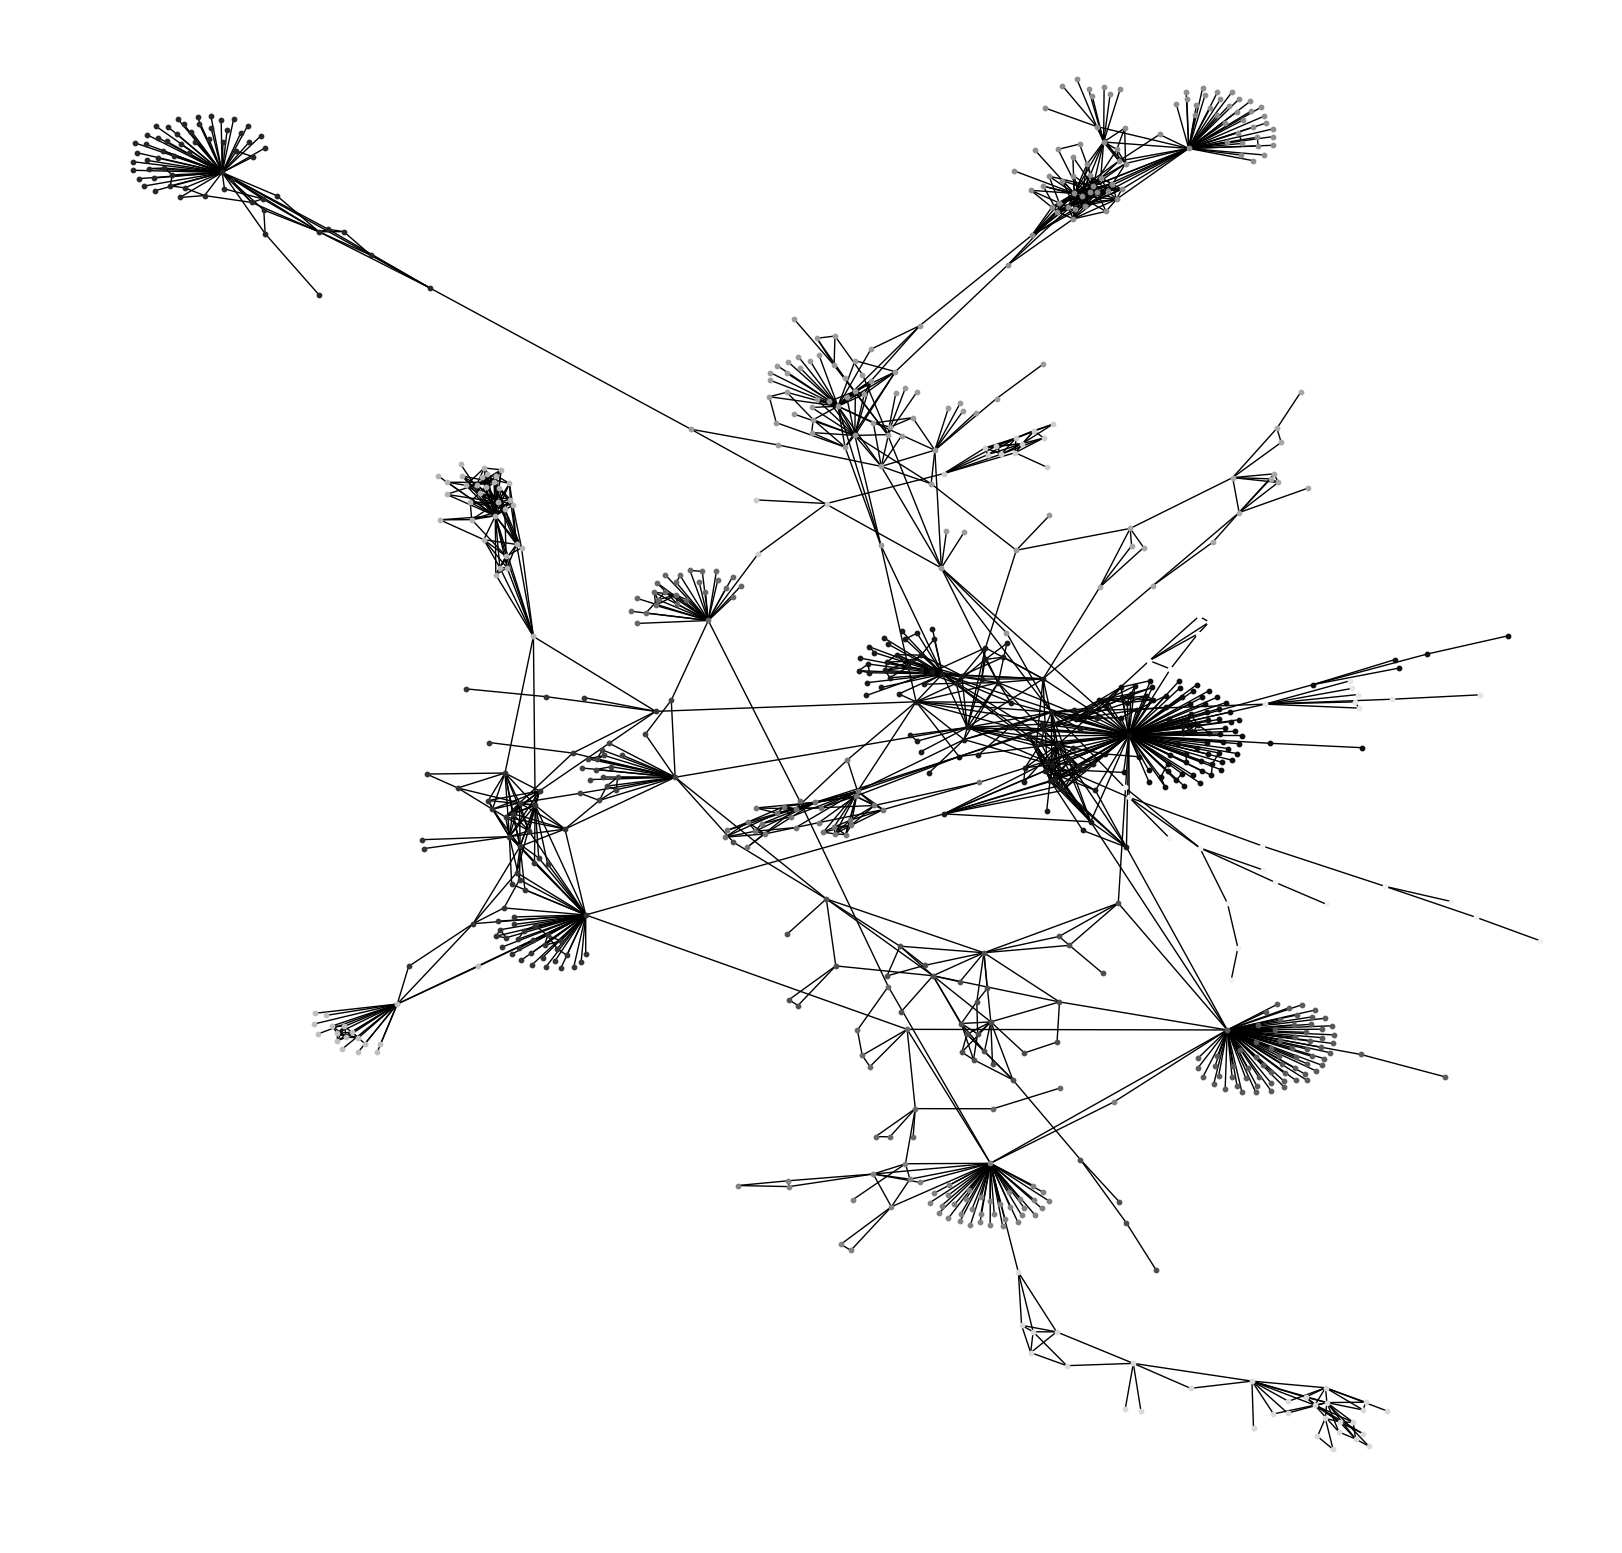

modularity: 0.8618249072991823


In [62]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)

size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 10,
                                node_color = str(count/ size))
nx.draw_networkx_edges(G, pos, alpha=1)
plt.show()
mod = community.modularity(partition,G)
print("modularity:", mod)

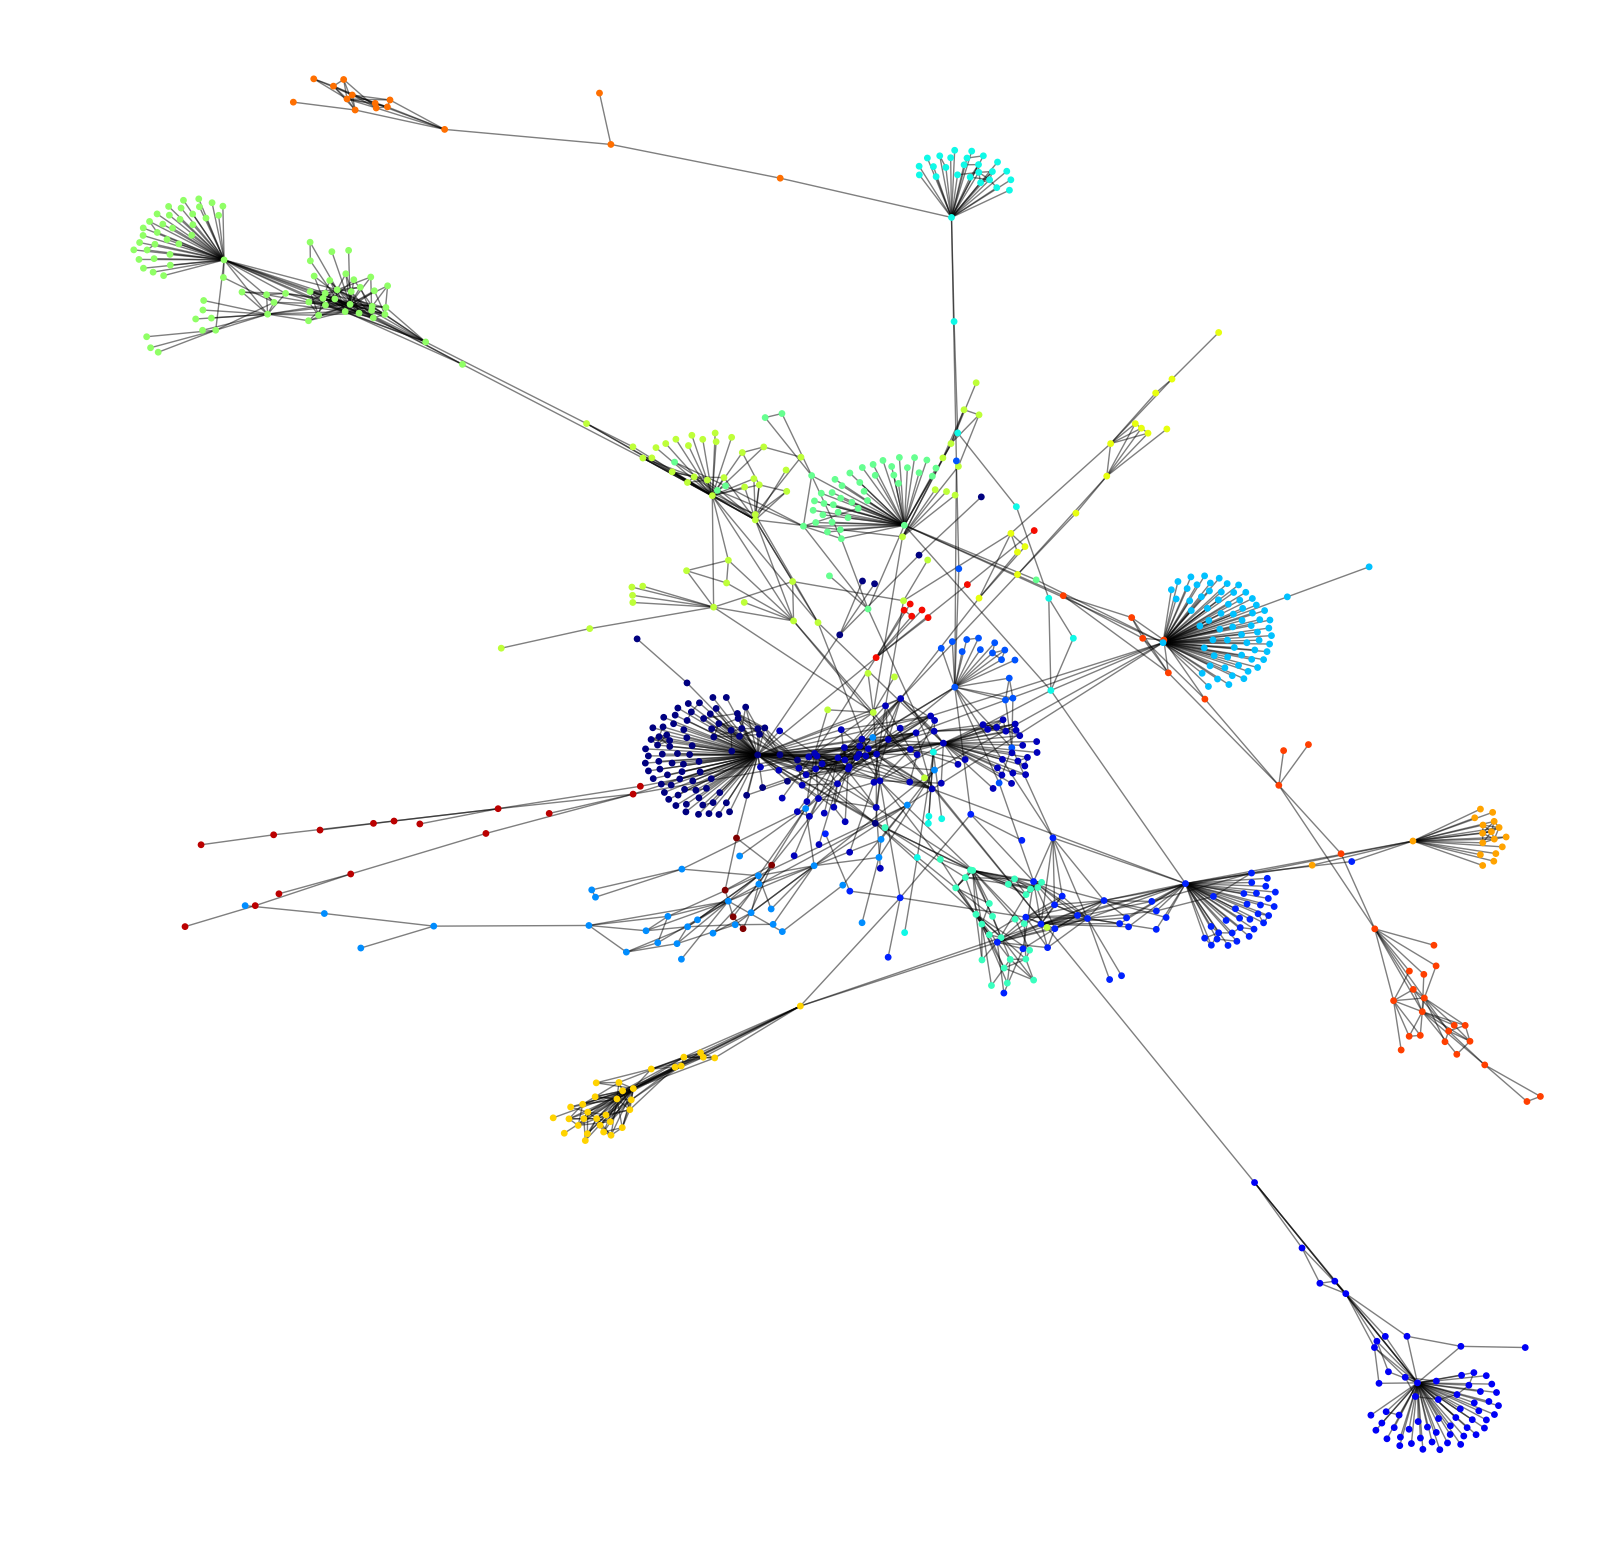

modularity: 0.8618249072991823


In [63]:
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
fig = plt.figure(1)
values = [partition.get(node) for node in G.nodes()]
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
mod = community.modularity(partition,G)
print("modularity:", mod)

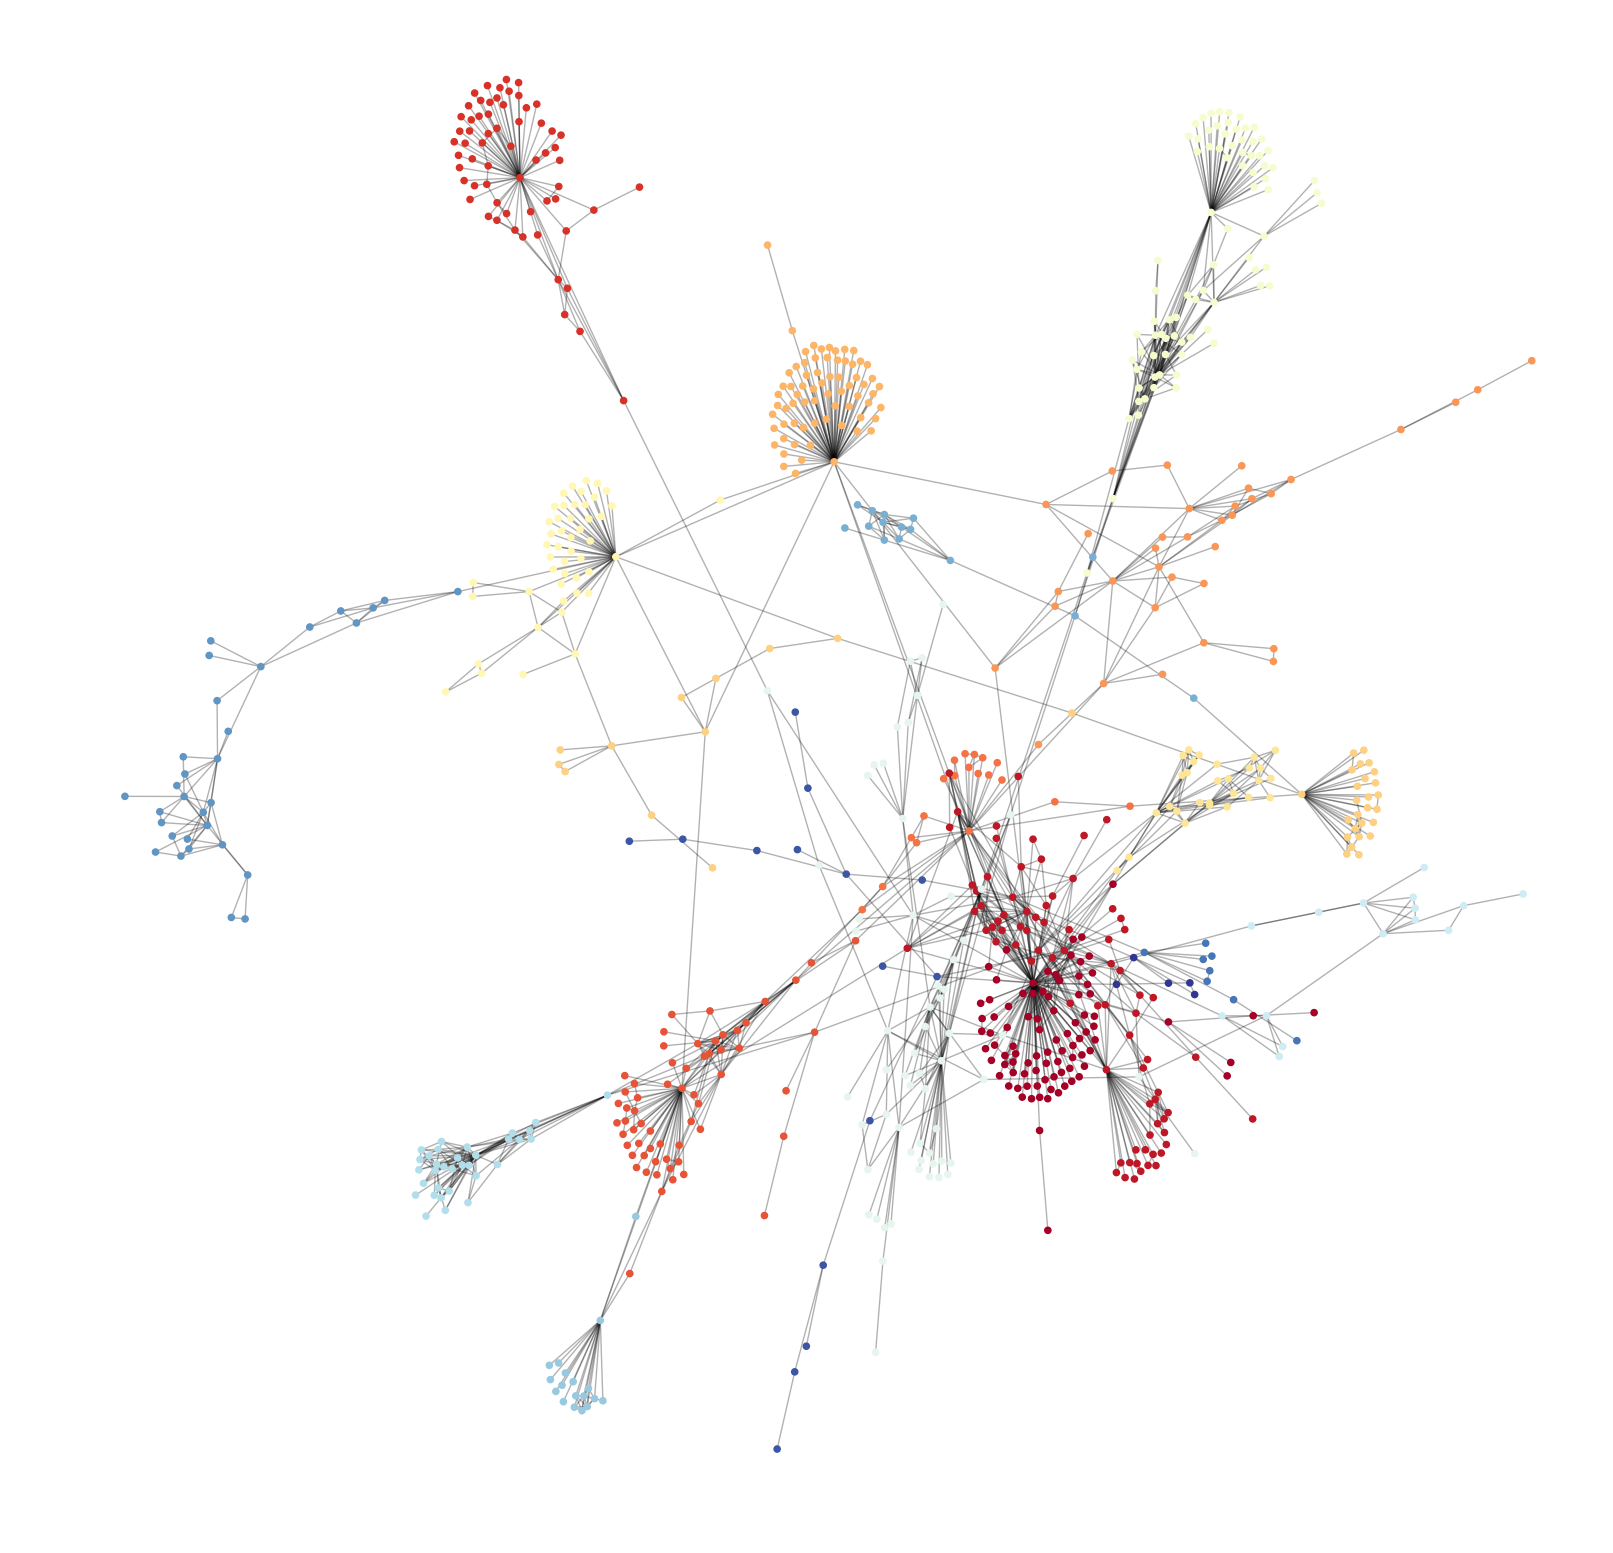

In [66]:
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(num=None, figsize=(20, 20), dpi=100)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

#算法解释
1）初始化：
将图中的每个节点看成一个独立的社区，社区的数目与节点个数相同；

2）开始first phase迭代 - 社区间节点转移：
对每个节点i，依次尝试把节点 i 分配到其每个邻居节点所在的社区，计算分配前与分配后的模块度变化ΔQ 

3）重复2）- 继续进行社区间节点转移评估：
直到所有节点的所属社区不再变化，即社区间的节点转移结束，可以理解为本轮迭代的 Local Maximization 已达到；

4）second phase - Rebuilding Graph：
因为在这轮的first phase中，社区 C 中新增了一个新的节点 i，而 i 所在的旧的社区少了一个节点，因此需要对整个图进行一个rebuild。

对图进行重构，将所有在同一个社区的节点重构成一个新社区，社区内节点之间的边的权重更新为新节点的环的权重，社区间的边权重更新为新节点间的边权重；

5）重复2）- 继续开始下一轮的first/second phase：
直到整个图的模块度不再发生变化。

In [ ]:
from collection import defaultdict
comm_dict=defaultdict(list)